# Hierarchical clustering basics

In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd                
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

from cnnclustering import cluster
from cnnclustering import plot
from cnnclustering import _types, _fit

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.8 (default, Mar 11 2021, 08:58:19) 
[GCC 8.3.0]


## Notebook configuration

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "../../matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

In [5]:
# Pandas DataFrame print options
pd.set_option('display.max_rows', 1000)

## Dissimilar blobs showcase

Learn in this tutorial how to use the `cnnclustering` module for step-wise hierarchical clusterings, where
one cluster step does not deliver a satisfactory result. We will also show how to use a data set of reduced size for cluster exploration and how we can transfer the result to the original full size data set.

We will generate a sample data set of three clusters that have very different point densities and are spatially not very well separated. As we will see,
it can be non-trivial (if not impossible) to extract all three clusters with a single set of cluster parameters. We will solve the problem by extracting the clusters in a two step procedure.

In [6]:
# Generate blobs with quite different point densities
dblobs, _ = datasets.make_blobs(
    n_samples=int(1e5),
    cluster_std=[3.5, 0.32, 1.8],
    random_state=1
    )

dblobs = StandardScaler().fit_transform(dblobs)

In [7]:
# Initialise clustering
clustering = cluster.prepare_clustering(dblobs)

In [8]:
# Get basic information about the clustering instance
print(clustering)

hierarchy_level: 0
input_data_kind: points
points: 100000
children: None


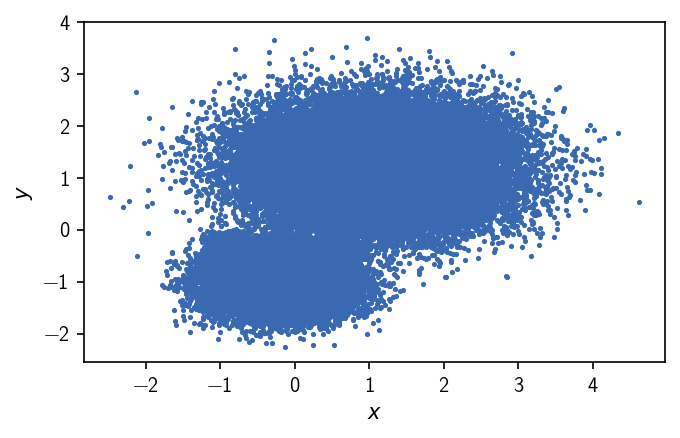

In [9]:
# Plot the original data
_ = clustering.evaluate()

Looking at this 2D plot of the generated points above we can already tell that this is probably not the easiest
of all clustering problems. One of the three clusters is hardly visible. We also have generated a fairly large amount of data points. If we have a big amount of computer-memory or enough time, we can attempt to cluster the 100,000 points directly. In terms of speed and for data exploration it might be, however, a good idea to perform the clustering on a reduced data set. We can predict the clustering later for the full sized set on the basis of the reduced result.

In [10]:
reduced_dblobs = dblobs[::100]
rclustering = cluster.prepare_clustering(reduced_dblobs)

We created a cluster object holding a smaller data set by using a point stride of 100, leaving us with only 1000 points that can be clustered very fast. A plot of the reduced set also shows that we made the clustering easier just judging by visual inspection. We can now clearly spot three point clouds.

Text(0.5, 1.0, '1000 points')

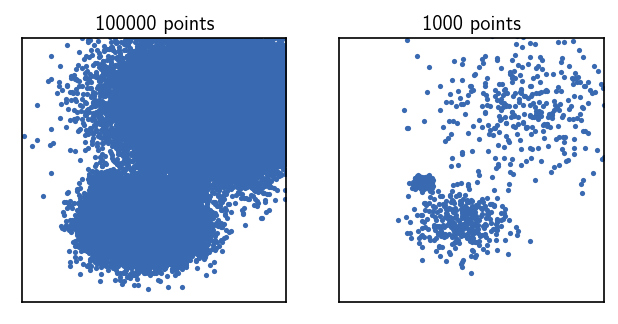

In [11]:
# Plot the reduced data
fig, Ax = plt.subplots(1, 2)
_ = clustering.evaluate(ax=Ax[0], ax_props=ax_props)
_ = rclustering.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[0].set_title(f"{clustering._input_data.n_points} points", fontsize=10, pad=4)
Ax[1].set_title(f"{rclustering._input_data.n_points} points", fontsize=10, pad=4)

When we pre-calculate pairwise point distances, we can plot the distribution of distances. This can give us a very basic estimate for a reasonable radius cutoff as one of the cluster parameters. For globular clusters with differing point density, each cluster should be visible as a peak in the distance distribution around a value that is very roughly equivalent to the radius of the point cloud. For more complicated data sets this approximation is not valid, but we can still get a feeling for the value range of meaningful radius cutoffs.

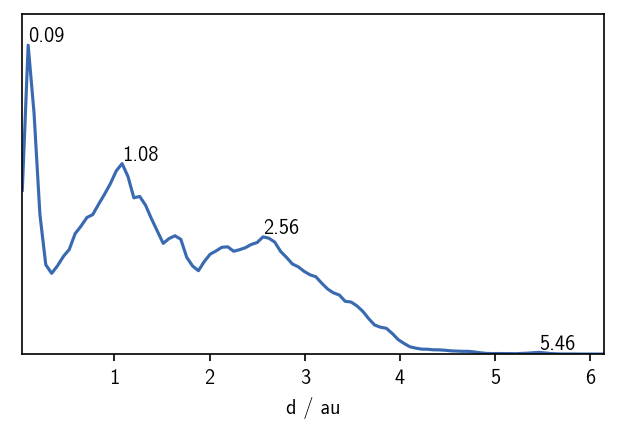

In [12]:
distances = pairwise_distances(rclustering.input_data)
distance_rclustering = cluster.prepare_clustering(distances)
distance_rclustering._metric = _types.MetricExtPrecomputed()

fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

### Parameter scan

Blindly starting to cluster a data set in a happy-go-lucky attempt may already lead to a satisfactory result in some cases, but let's tackle this problem in a more systematic way to see how different cluster parameters effect the outcome. A scan of a few parameters shows that it is difficult to extract the three clusters at once with one parameter set.

In [13]:
for r in [0.05, 0.08, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75, 1., 2.]:
    for c in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
        distance_rclustering.fit(r, c, member_cutoff=5, v=False)  # fit from pre-calculated distances

Each cluster result will be added to the `summary` attribute of our cluster object.

In [14]:
print(*distance_rclustering.summary[:5], sep="\n")

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
1000      0.050     0         5         None      13        0.329     0.555     00:00:0.004
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
1000      0.050     1         5         None      11        0.326     0.607     00:00:0.003
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
1000      0.050     2         5         None      5         0.31

If you have `pandas` installed, you can convert the summary to a nice table as a `pandas.DataFrame`. This makes the analysis of the cluster results more convenient.

In [15]:
# Get summary sorted by number of identified clusters
df = distance_rclustering.summary.to_DataFrame().sort_values('n_clusters')

# Show cluster results where we have 3 clusters
df[df.n_clusters == 3]

,n_points,radius_cutoff,cnn_cutoff,member_cutoff,max_clusters,n_clusters,ratio_largest,ratio_noise,execution_time
54,1000,0.25,0,5,<NA>,3,0.963,0.026,0.005310
98,1000,0.45,20,5,<NA>,3,0.661,0.152,0.008084
88,1000,0.40,15,5,<NA>,3,0.659,0.152,0.007433
71,1000,0.30,20,5,<NA>,3,0.614,0.326,0.007638
44,1000,0.15,20,5,<NA>,3,0.333,0.629,0.006231
66,1000,0.30,3,5,<NA>,3,0.667,0.060,0.005462
78,1000,0.35,10,5,<NA>,3,0.658,0.134,0.006439
68,1000,0.30,5,5,<NA>,3,0.660,0.105,0.005740
69,1000,0.30,10,5,<NA>,3,0.645,0.210,0.006125
3,1000,0.05,3,5,<NA>,3,0.315,0.675,0.003272


The summary shows indeed that we got 3 clusters (as desired) for a few parameter combinations. Apart from the number of clusters, it is, however often also of interest, how many data points ended up in the clusters and how many are considered outliers (noise). In this case we expect 3 clusters of more or less equal size (member wise) and we may be interested in keeping the outliers-level low. Of the results giving 3 clusters, 3 find the largest cluster to entail one third of the data points (which is good), but the noise level is around 50 % and higher (which is probably not what we want). Let's plot a few results to see what is going on here.

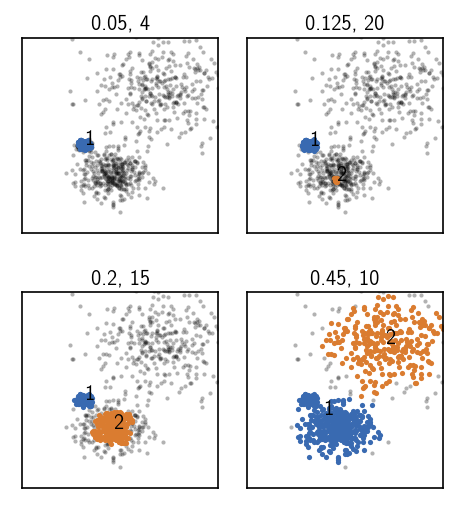

In [16]:
# Cluster attempts in comparison
fig, ax = plt.subplots(2, 2)
Ax = ax.flatten()
for i, pair in enumerate([(0.050, 4), (0.125, 20), (0.2, 15), (0.450, 10)]):
    distance_rclustering.fit(*pair, member_cutoff=5, record=False, v=False)
    rclustering._labels = distance_rclustering._labels
    
    _ = rclustering.evaluate(ax=Ax[i], ax_props=ax_props)
    Ax[i].set_title(f'{pair[0]}, {pair[1]}', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0.2, right=0.8, bottom=0, top=1, wspace=0, hspace=0.3 
    )

None of the above attempts was able to achieve a split into 3 clusters as we wanted it. One could now try to tinker around with the parameters a bit more, or resort to hierarchical clustering. As we see in the plots above (lower left and right), two different parameter pairs are leading to a clean split of different regions of the data, so why not apply both of them, one after the other.

Before we do this let's have another close look at the cluster results we obtained. Using the `summarize` method of a cluster object, we can visualize a summary table in a 2D contour plot, to evaluate a few quality measures versus the input parameters *radius cutoff* (*r*) and *similarity criterion* (*c*):

 - number of identified clusters
 - members in the largest cluster
 - points classified as outliers
 - computational time of the fit

In [17]:
cluster.Record.__slots__

['n_points',
 'radius_cutoff',
 'cnn_cutoff',
 'member_cutoff',
 'max_clusters',
 'n_clusters',
 'ratio_largest',
 'ratio_noise',
 'execution_time']

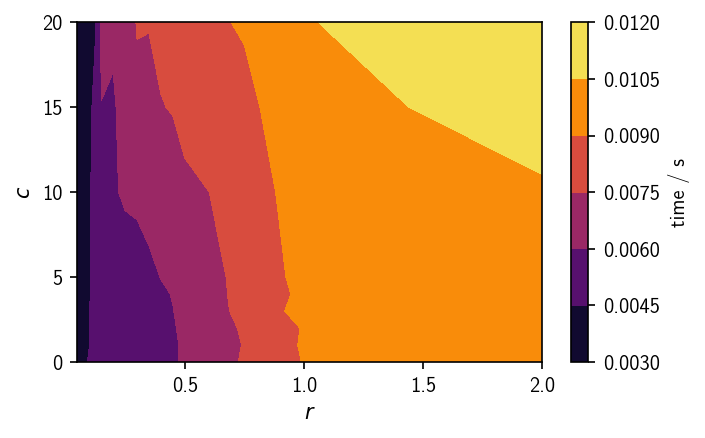

In [18]:
# Computing time
fig, ax = plt.subplots()
contour = distance_rclustering.summarize(ax=ax, quantity="execution_time")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("time / s")

From the *time vs. R/C* plot we can see how the total clustering time depends in particular on the neighbour search radius cutoff. Larger radii result in larger neighbourlists for each point, increasing the processing time so if one has the choice, smaller values for *r* should be preferred.

(0.05, 1.0)

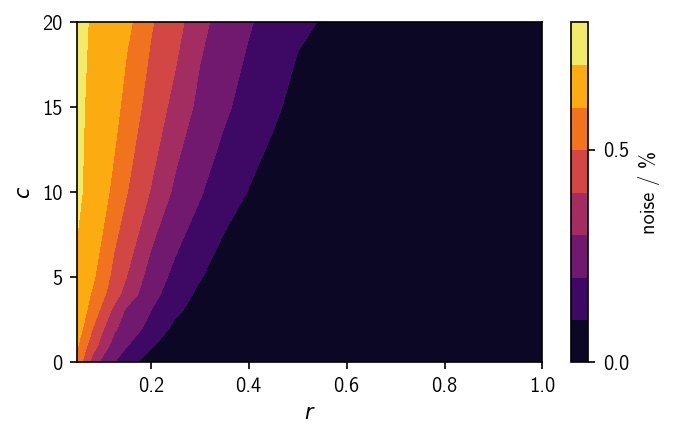

In [19]:
# Noise level
fig, ax = plt.subplots()
contour = distance_rclustering.summarize(ax=ax, quantity="ratio_noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("noise / %")
ax.set_xlim(None, 1)

The ratio of outlier-points depends on the search radius *r* as well as on the similarity criterion *c*. We can somewhat denote from this that cluster results with a similar noise-ratio (that are presumably similar qualitatively) are achieved for a variety of *r*/*c* combinations. If we increase *r* and *c* at the same time, the noise-level stays constant. The desired amount of noise depends much on the nature of the underlying data set. 

(0.05, 1.0)

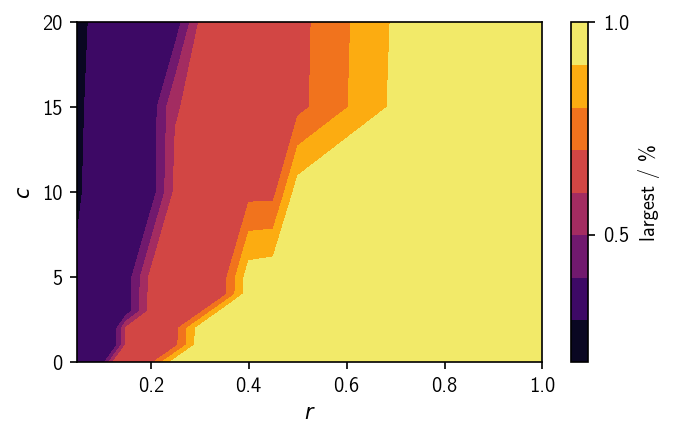

In [20]:
# Largest cluster
fig, ax = plt.subplots()
contour = distance_rclustering.summarize(ax=ax, quantity="ratio_largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("largest / %")
ax.set_xlim(None, 1)

The ratio of points assigned to the largest cluster show a similar trend as the noise-ratio. This view could give a good hint towards reasonable parameter combinations if one already has an idea about the expected cluster size. It also shows for which parameters we do not observe any splitting (about 100 % of the points are in the largest cluster. 

(0.05, 1.0)

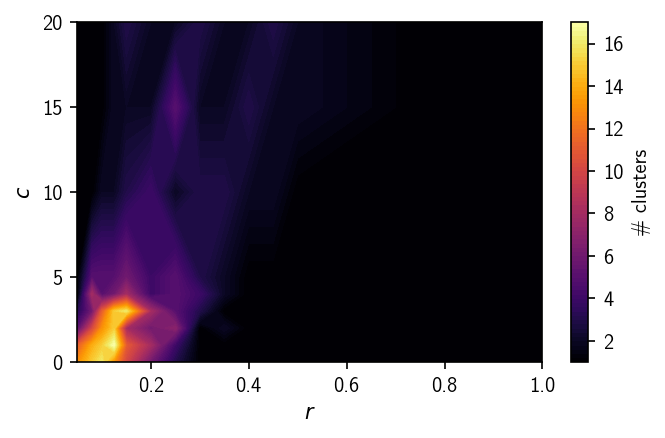

In [21]:
# Number of clusters
fig, ax = plt.subplots()
contour = distance_rclustering.summarize(
    ax=ax, quantity="n_clusters",
    contour_props={"levels": 100}
)[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=range(0, 17, 2))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("# clusters")
ax.set_xlim(None, 1)

(0.05, 1.0)

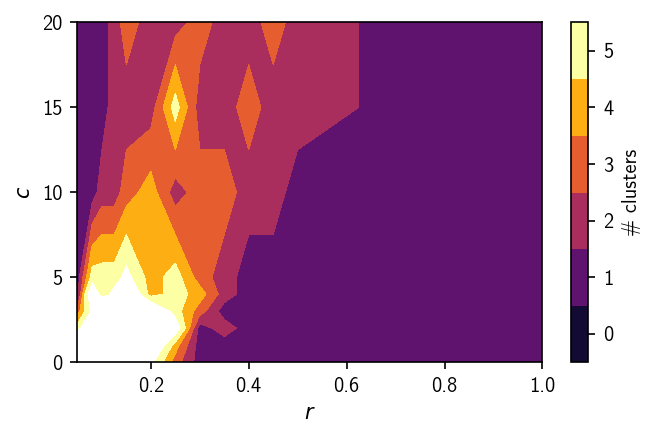

In [22]:
# cluster number with adjusted coloring
fig, ax = plt.subplots()
contour = distance_rclustering.summarize(
    ax=ax, quantity="n_clusters",
    contour_props={"levels": [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
                   "vmax": 5}
    )[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 1, 2, 3, 4, 5))
ax.set_yticks([0, 5, 10, 15, 20])
colorbar.set_label("# clusters")
ax.set_xlim(None, 1)

The probably most telling view is given by the *number of clusters* plots. The analysis demonstrates nicely that for this data set a splitting into 3 meaningful clusters is hard to achieve.

### Hierarchical clustering

To use the hierarchical approach to clustering this data set, we will apply a pair of cluster parameters that will extract the lesser dense region of the data as an isolated cluster in a first step. That means we choose a comparably large value for the neighbour search radius *r* and a rather low value for the similarity criterion *c*. We can refer to these parameters as *soft* parameters, leaving the more dense regions of the data untouched and in one cluster. Remember that density in terms of common-nearest-neighbour clustering is estimated as the number of common neighbours within the neighbourhood intersection of two points with respect to a radius *r*. More common neighbours (higher similarity cutoff *c*) and/or a smaller neighbourhood radius (smaller *r*) will result in a higher density requirement. To make this more clear let's have a look again at some clusterings. 

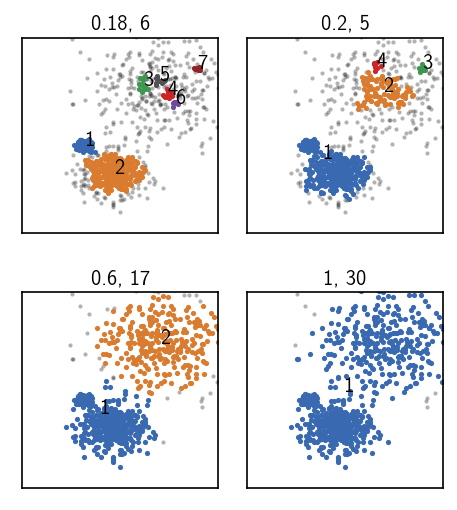

In [23]:
# Cluster attempts in comparison
fig, ax = plt.subplots(2, 2)
Ax = ax.flatten()
for i, pair in enumerate([(0.18, 6), (0.2, 5), (0.6, 17), (1, 30)]):
    distance_rclustering.fit(*pair, member_cutoff=5, record=False, v=False)
    rclustering._labels = distance_rclustering._labels
    _ = rclustering.evaluate(ax=Ax[i], ax_props=ax_props)
    Ax[i].set_title(f'{pair[0]}, {pair[1]}', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0.2, right=0.8, bottom=0, top=1, wspace=0, hspace=0.3 
    )

__Lower right__: Choosing a high radius cutoff ($r=1$), i.e. a soft density requirement, results in no cluster splitting. The data set as a whole forms clusters in which the point density is *at least* as high as our density requirement.

__Lower left__: When we increase the density requirement ($r=0.6$, $c=17$), we observe a splitting between the broadly distributed lower density cluster and the more dense clusters. Within both the resulting clusters the point density is higher than required by the parameters but they are separated by a low density region and therefore split. This parameter set can be used for the first step of the hierarchical clustering.

__Upper right__: Increasing the density requirement further ($r=0.2$, $c=5$), leads to a splitting within the broad cluster first, while the more dense clusters still remain united. Obviously, the point density in the region between the two dense clusters is higher than in parts within the low density cluster.

__Upper left__: Choosing parameters hard enough ($r=0.18$, $c=6$) to achieve a splitting of the two dense clusters, does also completely split up the less dense cluster. We could use this parameter set in a second hierarchical clustering step.

The central element of the hierarchical cluster functionality is the `isolate` method of a cluster object. After a clustering (with soft parameters) we can *freeze* the result before we start to re-cluster. 

In [24]:
# After the first step, we need to isolate the cluster result
rclustering.fit(0.6, 17, member_cutoff=5, record=False, v=False)
rclustering.isolate()

The `isolate` method will create a new cluster object (a child cluster) for every cluster of a cluster result.
In our case we get two new child clusters (plus one for outliers). The clusters are stored in a dictionary under the `children` attribute of the parent cluster object. The children dictionary of the data after isolation holds a cluster object for each cluster found in the last step.

In [25]:
{k: type(v) for k, v in rclustering._children.items()}

{1: cnnclustering.cluster.ClusteringChild,
 2: cnnclustering.cluster.ClusteringChild,
 0: cnnclustering.cluster.ClusteringChild}

Since we will use different cluster parameters now for different clusters it would be nice to have something
to keep the overview of which cluster has been identified under which parameters. This information is provided by `labels.meta`. A label info tells us three things:

  - `origin`: How have these labels been assigned? The entry `"fit"` means, they were obtained by a regular clustering.
  - `reference`: This is a related clustering object, i.e. the object that is associated to the data for which the labels are valid. For `"fitted"` labels this is a reference to the clustering object itself that carries the labels.
  - `params`: This is a dictionary stating the cluster parameters (*r*, *c*) that led to each cluster. For `"fitted"` labels, each cluster has the same parameters.

In [26]:
print(rclustering._labels.meta)

{'params': {1: (0.6, 17), 2: (0.6, 17)}, 'reference': <weakproxy at 0x7f3be6647db0 to Clustering at 0x7f3bebfa16a0>, 'origin': 'fit'}


Every single isolated child cluster is a full-fledged, completely functional cluster object itself. When we want to re-cluster a child cluster, this is no different to clustering a parent cluster. 

In [27]:
child1 = rclustering._children[1]
print(child1)  # Child cluster 1

hierarchy_level: 1
input_data_kind: points
points: 678
children: None


Note, that the `hierarchy level` in the above overview has increased to 1. We can again plot the distance distribution within this child cluster to see how this changed.

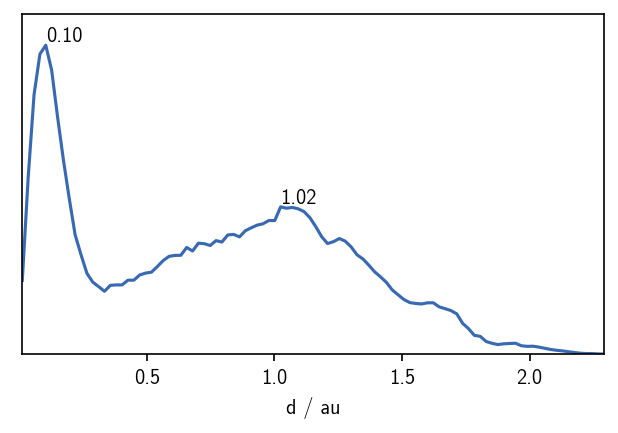

In [28]:
distances_child1 = pairwise_distances(child1.input_data)
fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances_child1, maxima=True, maxima_props={"order": 5})

And then we can attempt the second clustering step. Very small clusters may appear in the result. To filter those out because they are irrelevant, we can use the `member_cutoff` keyword argument of the `fit` method.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
678       0.180     6         None      None      22        0.494     0.090     00:00:0.009
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
678       0.180     6         5         None      2         0.494     0.124     00:00:0.009
-----------------------------------------------------------------------------------------------



Text(0.5, 1.0, 'member cutoff 5')

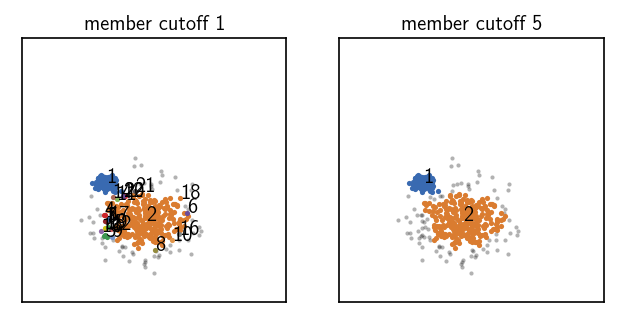

In [29]:
# Now cluster the child cluster
fig, Ax = plt.subplots(1, 2)
child1.fit(0.18, 6)
_ = child1.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[0].set_title(f"member cutoff 1", fontsize=10, pad=4)

# When the result is satisfying, but also a few very small clusters are found,
# this can be surpressed
child1.fit(0.18, 6, member_cutoff=5)
_ = child1.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[1].set_title(f"member cutoff 5", fontsize=10, pad=4)

As a little extra feature a cluster object has a `pie` method that allows to visualize the current state and splitting on the different hierarchy levels as a pie-diagram (from level 0 in the middle to lower levels to the outside).

(-0.3, 0.3)

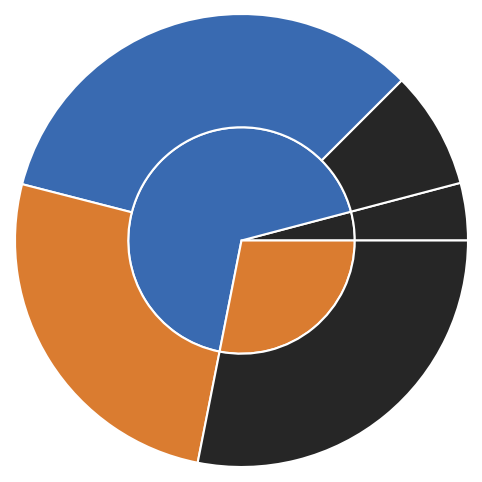

In [30]:
# The cluster hierarchy can be visualised as pie diagram
fig, ax, *plotted = rclustering.pie(
    pie_props={"radius": 0.2,
    "wedgeprops": dict(width=0.2, edgecolor='w')}
)
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)

Now that we have isolated one cluster in the first step and two others in a further splitting on a lower hierarchy level, the last step that remains, is to put everything back together. This can be done automatically by calling `reel` on the parent cluster object into which the child cluster results should be integrated.

In [31]:
# Wrap up the hierarchical clustering and integrate the child clusters into
# the parent cluster
rclustering.reel()

# Manually sort clusters by size (make largest be cluster number 1)
rclustering._labels.sort_by_size()  

(-0.3, 0.3)

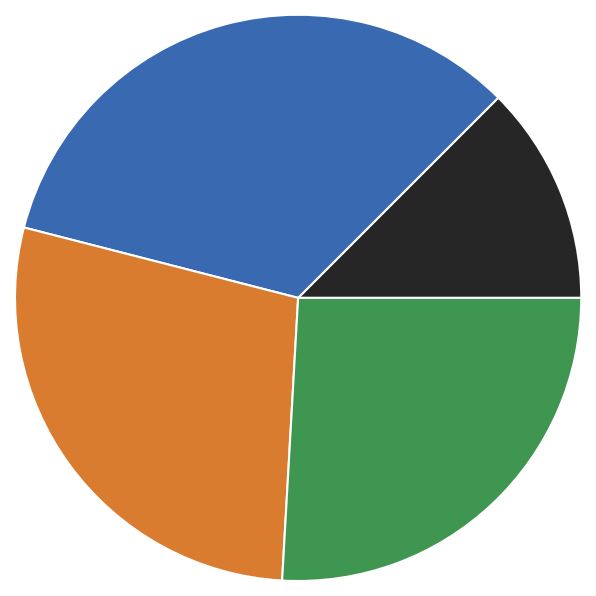

In [32]:
rclustering._children = None
fig, ax, *plotted = rclustering.pie()
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)

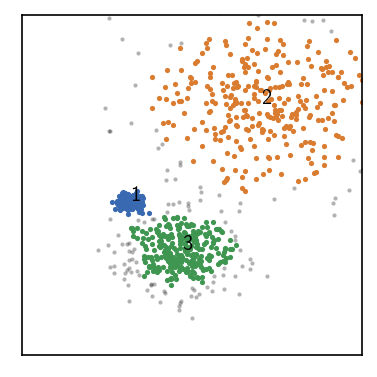

In [33]:
fig, ax = plt.subplots()
_ = rclustering.evaluate(ax=ax, ax_props=ax_props)

### Label prediction

Now the parameter information becomes useful as they differ for the clusters from different clustering steps.

In [34]:
rclustering._labels.meta

{'params': {2: (0.6, 17), 3: (0.18, 6), 1: (0.18, 6)},
 'reference': <weakproxy at 0x7f3be6647db0 to Clustering at 0x7f3bebfa16a0>,
 'origin': 'reel'}

In [35]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(rclustering._labels.meta["params"].items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	0.18	6
2	0.6	17
3	0.18	6


The cluster result is satisfying. But we have clustered only a reduced set of 1000 points. We would like to predict the cluster label assignment for the full 100,000 points on the basis of the reduced set assignments. This we can do with the `predict` method of a cluster object. We call `predict` with another cluster object for which labels should be predicted as an argument. Similar to a regular `fit` we need to compute neighbourhoods for the points that need assignment, but this time we need relative neighbourhoods between two data sets. We want to compute the neighbouring points in the small set `rclustering` for the points in the big set `clustering`. To allow the fast computation of these neighbourhoods we could calculate a relative pairwise distance matrix for distances from points in `clustering` to points in `rclustering` (a so called map matrix). When we predict labels afterwards we should do the prediction separately for the clusters because the assignment parameters differ. This is where the label info comes in handy showing us the parameters used for the fit as an orientation.

Text(0.5, 1.0, '3 (0.16, 8)')

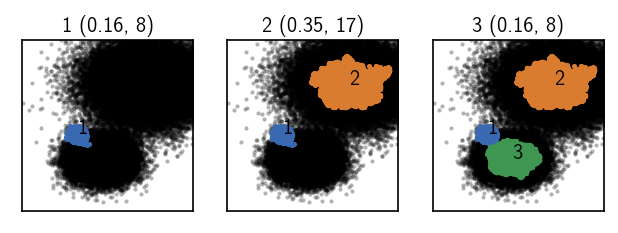

In [36]:
rclustering._predictor = _fit.PredictorFirstmatch()

fig, Ax = plt.subplots(1, 3)

r = 0.16; c = 8
rclustering.predict(clustering, r, c, clusters=[1], purge=True)
_ = clustering.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[0].set_title(f'1 {(r, c)}', fontsize=10, pad=4)

r = 0.35; c = 17
rclustering.predict(clustering, r, c, clusters=[2])
_ = clustering.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[1].set_title(f'2 {(r, c)}', fontsize=10, pad=4)

r = 0.16; c = 8
rclustering.predict(clustering, r, c, clusters=[3])
_ = clustering.evaluate(ax=Ax[2], ax_props=ax_props)
Ax[2].set_title(f'3 {(r, c)}', fontsize=10, pad=4)

In [37]:
print("Label", "r", "n", sep="\t")
print("-" * 20)
for k, v in sorted(clustering._labels.meta["params"].items()):
    print(k, *v, sep="\t")

Label	r	n
--------------------
1	0.16	8
2	0.35	17
3	0.16	8
